In [1]:
##libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf

In [2]:
##project constant
RAW_DIR="data/Art"
IMG_HEIGHT=180
IMG_WIDTH=180
EPOCH=10
BATCH_SIZE=16
SEED=42
CHANNELS=3

In [3]:
##loading dataset
raw_data=tf.keras.preprocessing.image_dataset_from_directory(
   RAW_DIR,
   image_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   shuffle=True 
)

Found 971 files belonging to 2 classes.


In [6]:
##checking class names
art_class=raw_data.class_names

In [5]:
##number of class
n_class=len(raw_data.class_names)
n_class

2

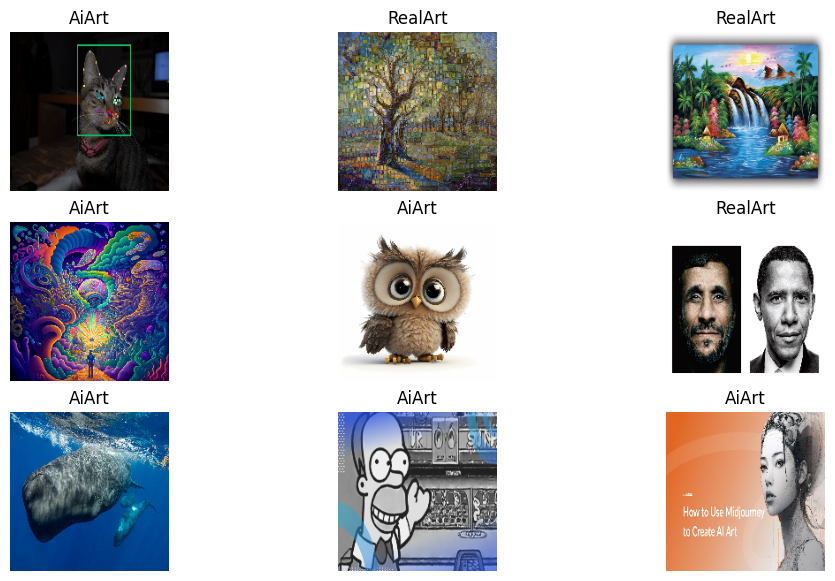

In [11]:
##show image
plt.figure(figsize=(12,7))
for image, label in raw_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(art_class[label[i]])
        plt.axis('off')
plt.show()

In [ ]:
##data splitter function
def data_splitter(image_path, 
                  train_split_size=0.8, 
                  val_split_size=0.1, 
                  test_split_size=0.1, 
                  shuffle=True,
                  shuffle_size=1000):
    pass